# Experiments: TensorFlow Lite applications analysis for both with and without HTTP handling implementation

This notebook allows to run every experiments used to analyze the capabilities of the two implmentations of the TensorFlow Lite application, i.e. with and without HTTP handling capability.

In [2]:
# Imports
import os
import re
import sys
import ast
import time
import pathlib
import datetime
import itertools
import textwrap
import numpy as np
import subprocess
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Global variables

# Paths
global_res_dir = "./results"
assets_path="./assets"


In [4]:
# ssh and scp functions with arguements
ssh_with_args = "ssh -o UserKnownHostsFile=/dev/null -o StrictHostKeyChecking=no"
scp_with_args = "scp -o UserKnownHostsFile=/dev/null -o StrictHostKeyChecking=no"

## Experiment 1: Analysis of the execution time of each important part of the TensorFlow Lite application for classical setup

In [28]:
# Experiment setup
experiment_name = "Execution time by part"
timestamp = timestamp=datetime.datetime.now() # Current timestamp

iteration = 20
ssh_info = "pptc@192.168.88.3"
ssh_ip = "192.168.88.3"
implementations = ["label_image", "label_image_with_crow"]
mediums = ["WiFi 2.4GHz 20-40MHz", "WiFi 5.0GHz 20-40-80MHz", "Ethernet"]
count_for_usage_script = 30 # correspond to the number of measure taken (1 per second)

### Perform experiment

In [6]:
# Experiment path
exp_folder_name = experiment_name.replace(' ', '_') + "_" + timestamp.strftime("%Y%m%dT%H%M%S")
exp_folder_name = experiment_name.replace(' ', '_') + "_20240811T171610"
curr_exp_dir = global_res_dir + "/" + exp_folder_name

# Remote path
remote_exp_results_dir = "~/" + exp_folder_name + "/results"
remote_exp_cpu_usage_dir = remote_exp_results_dir + "/cpu_usage"
remote_exp_ram_usage_dir = remote_exp_results_dir + "/ram_usage"
remote_exp_scripts_dir = "~/" + exp_folder_name + "/scripts"

# Copy scripts on remote device
!{ssh_with_args} {ssh_info} "mkdir -p ~/{exp_folder_name}"
!{scp_with_args} -r scripts/ {ssh_info}:~/{exp_folder_name}

# Perform the experiment
for imp in implementations:
    imp_mediums = ["na"] if imp == "label_image" else mediums

    # Copy needed assets (executable and images)
    print(f"Copy assets for {imp} on remote device")
    !{scp_with_args} -r {assets_path}/{imp} {ssh_info}:~/{exp_folder_name}/{imp}

    for med in imp_mediums:
        # Validate config:
        print(f"Prepare next config:\n\tImplementation: {imp}\n\tMedium: {med}\n\t\n")
        time.sleep(2)
        v = input("Press ENTER to run the benchmark")
        print(f"Value : {v}")
        if v == "s": # stop
            break
        print("Run benchmark...")

        # Create remote workspace
        !{ssh_with_args} {ssh_info} "mkdir -p {remote_exp_cpu_usage_dir}; mkdir -p {remote_exp_ram_usage_dir}"

        # Implementation paths
        curr_exp_imp_dir = curr_exp_dir + "/" + imp.replace(' ', '_')
        curr_exp_imp_med_dir = curr_exp_imp_dir + ("/" + med.replace(' ', '_') if med != "na" else "")
        curr_exp_imp_raw_dir = curr_exp_imp_med_dir + "/raw_results"
        curr_exp_imp_raw_file = curr_exp_imp_raw_dir + "/execution_time_by_part.txt"
        curr_exp_imp_res_dir = curr_exp_imp_med_dir + "/results"

        # Remote paths
        cpu_usage_remote_file = remote_exp_cpu_usage_dir + "/results_cpu_usage_" + imp + "_" + med.replace(' ', '_') + ".txt"
        ram_usage_remote_file = remote_exp_ram_usage_dir + "/results_ram_usage_" + imp + "_" + med.replace(' ', '_') + ".txt"

        # Create results dir
        path = Path(curr_exp_dir)
        path.mkdir(parents=True, exist_ok=True)
        path = Path(curr_exp_imp_dir)
        path.mkdir(parents=True, exist_ok=True)
        path = Path(curr_exp_imp_raw_dir)
        path.mkdir(parents=True, exist_ok=True)
        path = Path(curr_exp_imp_res_dir)
        path.mkdir(parents=True, exist_ok=True)

        # Print experiment setup in results file
        # Local for execution time
        with open(curr_exp_imp_raw_file, "w") as raw:
            raw.write(f"# SSH_INFO={ssh_info}\n")
            raw.write(f"# ITERATIONS={iteration}\n")
            raw.write(f"# IMPLEMENTATION={imp}\n")
            raw.write(f"# MEDIUM={med}\n")

        # Remote for cpu and ram usage
        !{ssh_with_args} {ssh_info} "echo -e \"# SSH_INFO={ssh_info}\n# ITERATIONS={iteration}\n# IMPLEMENTATION={imp}\n# MEDIUM={med}\n# COUNT={count_for_usage_script}\n\" > {cpu_usage_remote_file}"
        !{ssh_with_args} {ssh_info} "echo -e \"# SSH_INFO={ssh_info}\n# ITERATIONS={iteration}\n# IMPLEMENTATION={imp}\n# MEDIUM={med}\n# COUNT={count_for_usage_script}\n\" > {ram_usage_remote_file}"

        # Perform test
        for i in range(iteration):
            # Print iteration
            print(f"Iteration {i}")
            with open(curr_exp_imp_raw_file, "a") as raw:
                raw.write(f"\n# ITERATION {i}\n")
            !{ssh_with_args} {ssh_info} "echo -e \"\n# ITERATION {i}\n\" >> {cpu_usage_remote_file}"
            !{ssh_with_args} {ssh_info} "echo -e \"\n# ITERATION {i}\n\" >> {ram_usage_remote_file}"

            # Run cpu and ram usage script
            print("Start CPU and RAM usage scripts")
            
            cpu_usage_process = subprocess.Popen(f'{ssh_with_args} {ssh_info} "{remote_exp_scripts_dir}/cpu_usage_script.sh {count_for_usage_script} {cpu_usage_remote_file} 0"', shell=True)
            ram_usage_process = subprocess.Popen(f'{ssh_with_args} {ssh_info} "{remote_exp_scripts_dir}/ram_usage_script.sh {count_for_usage_script} {ram_usage_remote_file} 0"', shell=True)

            print("Sleep 3s")
            time.sleep(3) # To have more usage measures

            
            print("Perform measure")
            if imp == "label_image":
                start_timestamp = int(datetime.datetime.now().timestamp()) # Timestamp at which the inference request started
                !{ssh_with_args} {ssh_info} "cd ~/{exp_folder_name}/{imp}; (time ./{imp} -m mobilenet_v1_1.0_224.tflite -l labels.txt -i grace_hopper.bmp -t 1 -d 1)" &>> {curr_exp_imp_raw_file}

                stop_timestamp = int(datetime.datetime.now().timestamp()) # Timestamp at which the inference request started
            else:
                server_process = subprocess.Popen(f'{ssh_with_args} {ssh_info} "cd ~/{exp_folder_name}/{imp}; ./{imp} -c config.json"', shell=True)
                time.sleep(3)
                
                start_timestamp = int(datetime.datetime.now().timestamp()) # Timestamp at which the inference request started
                !(time curl -X POST -F "image=@{assets_path}/label_image_with_crow/grace_hopper.bmp" http://{ssh_ip}:18080/label_image) &>> {curr_exp_imp_raw_file}

                stop_timestamp = int(datetime.datetime.now().timestamp()) # Timestamp at which the inference request started
                
                # Kill server
                print("Kill server")
                server_process.kill()
                !{ssh_with_args} {ssh_info} 'kill $(pidof {imp})'


            print("Sleep 3s")
            time.sleep(3)  # To have more usage measures

            print("Kill CPU and RAM usage scripts")
            cpu_usage_process.kill()
            ram_usage_process.kill()
            !{ssh_with_args} {ssh_info} 'kill $(pidof cpu_usage_script.sh)'
            !{ssh_with_args} {ssh_info} 'kill $(pidof ram_usage_script.sh)'

            !{ssh_with_args} {ssh_info} "echo \"# TIMESTAMP_START={start_timestamp}\" >> {cpu_usage_remote_file}; echo \"# TIMESTAMP_STOP={stop_timestamp}\" >> {cpu_usage_remote_file}"
            !{ssh_with_args} {ssh_info} "echo \"# TIMESTAMP_START={start_timestamp}\" >> {ram_usage_remote_file}; echo \"# TIMESTAMP_STOP={stop_timestamp}\" >> {ram_usage_remote_file}"

        print("Retrieve usage results and remove remote workspace")
        !{scp_with_args} -r {ssh_info}:{remote_exp_cpu_usage_dir} {curr_exp_imp_raw_dir}
        !{scp_with_args} -r {ssh_info}:{remote_exp_ram_usage_dir} {curr_exp_imp_raw_dir}

        !{ssh_with_args} {ssh_info} "rm -rf {remote_exp_cpu_usage_dir}; rm -rf {remote_exp_ram_usage_dir}"

# Remove remote workspace
!{ssh_with_args} {ssh_info} "rm -rf ~/{exp_folder_name}"

cpu_usage_script.sh                           100% 1189   583.1KB/s   00:00    
ram_usage_script.sh                           100% 1253   729.4KB/s   00:00    
Copy assets for label_image_with_crow on remote device
scp: /home/pptc/Execution_time_by_part_20240811T171610/label_image_with_crow/label_image_with_crow: Not a directory
Prepare next config:
	Implementation: label_image_with_crow
	Medium: Ethernet
	

Value : 
Run benchmark...
Iteration 0
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 15:55:17) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 15:55:17) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 15:55:20) [INFO    ] Request: 192.168.88.200:53818 0xb5cbc200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 15:55:21) [INFO    ] Response: 0xb5cbc200 /label_image 200 0


Sleep 3s


(2024-08-11 15:55:21) [INFO    ] Closing IO service 0xb577c6f0
(2024-08-11 15:55:21) [INFO    ] Closing IO service 0xb577c6f4
(2024-08-11 15:55:21) [INFO    ] Closing IO service 0xb577c6f8
(2024-08-11 15:55:21) [INFO    ] Closing main IO service (0xb5caa4dc)
(2024-08-11 15:55:21) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 1
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 15:55:31) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 15:55:31) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 15:55:33) [INFO    ] Request: 192.168.88.200:42356 0xb5cb0200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 15:55:34) [INFO    ] Response: 0xb5cb0200 /label_image 200 0


Sleep 3s


(2024-08-11 15:55:35) [INFO    ] Closing IO service 0xb57706f0
(2024-08-11 15:55:35) [INFO    ] Closing IO service 0xb57706f4
(2024-08-11 15:55:35) [INFO    ] Closing IO service 0xb57706f8
(2024-08-11 15:55:35) [INFO    ] Closing main IO service (0xb5c9e4dc)
(2024-08-11 15:55:35) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 2
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 15:55:44) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 15:55:44) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 15:55:47) [INFO    ] Request: 192.168.88.200:34768 0xb5d53200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 15:55:48) [INFO    ] Response: 0xb5d53200 /label_image 200 0


Sleep 3s


(2024-08-11 15:55:48) [INFO    ] Closing IO service 0xb58136f0
(2024-08-11 15:55:48) [INFO    ] Closing IO service 0xb58136f4
(2024-08-11 15:55:48) [INFO    ] Closing IO service 0xb58136f8
(2024-08-11 15:55:48) [INFO    ] Closing main IO service (0xb5d414dc)
(2024-08-11 15:55:48) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 3
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 15:55:57) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 15:55:57) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 15:56:00) [INFO    ] Request: 192.168.88.200:56582 0xb5c9c200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 15:56:01) [INFO    ] Response: 0xb5c9c200 /label_image 200 0


Sleep 3s


(2024-08-11 15:56:02) [INFO    ] Closing IO service 0xb575c6f0
(2024-08-11 15:56:02) [INFO    ] Closing IO service 0xb575c6f4
(2024-08-11 15:56:02) [INFO    ] Closing IO service 0xb575c6f8
(2024-08-11 15:56:02) [INFO    ] Closing main IO service (0xb5c8a4dc)
(2024-08-11 15:56:02) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 4
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 15:56:11) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 15:56:11) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 15:56:14) [INFO    ] Request: 192.168.88.200:57842 0xb5ca2200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 15:56:14) [INFO    ] Response: 0xb5ca2200 /label_image 200 0


Sleep 3s


(2024-08-11 15:56:15) [INFO    ] Closing IO service 0xb57626f0
(2024-08-11 15:56:15) [INFO    ] Closing IO service 0xb57626f4
(2024-08-11 15:56:15) [INFO    ] Closing IO service 0xb57626f8
(2024-08-11 15:56:15) [INFO    ] Closing main IO service (0xb5c904dc)
(2024-08-11 15:56:15) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 5
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 15:56:24) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 15:56:24) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 15:56:27) [INFO    ] Request: 192.168.88.200:49998 0xb5ca1200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 15:56:27) [INFO    ] Response: 0xb5ca1200 /label_image 200 0


Sleep 3s


(2024-08-11 15:56:28) [INFO    ] Closing IO service 0xb57616f0
(2024-08-11 15:56:28) [INFO    ] Closing IO service 0xb57616f4
(2024-08-11 15:56:28) [INFO    ] Closing IO service 0xb57616f8
(2024-08-11 15:56:28) [INFO    ] Closing main IO service (0xb5c8f4dc)
(2024-08-11 15:56:28) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 6
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 15:56:37) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 15:56:37) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 15:56:40) [INFO    ] Request: 192.168.88.200:40942 0xb5cb8200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 15:56:40) [INFO    ] Response: 0xb5cb8200 /label_image 200 0


Sleep 3s


(2024-08-11 15:56:41) [INFO    ] Closing IO service 0xb57786f0
(2024-08-11 15:56:41) [INFO    ] Closing IO service 0xb57786f4
(2024-08-11 15:56:41) [INFO    ] Closing IO service 0xb57786f8
(2024-08-11 15:56:41) [INFO    ] Closing main IO service (0xb5ca64dc)
(2024-08-11 15:56:41) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 7
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 15:56:50) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 15:56:50) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 15:56:53) [INFO    ] Request: 192.168.88.200:45204 0xb5d30200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 15:56:54) [INFO    ] Response: 0xb5d30200 /label_image 200 0


Sleep 3s


(2024-08-11 15:56:54) [INFO    ] Closing IO service 0xb57f06f0
(2024-08-11 15:56:54) [INFO    ] Closing IO service 0xb57f06f4
(2024-08-11 15:56:54) [INFO    ] Closing IO service 0xb57f06f8
(2024-08-11 15:56:54) [INFO    ] Closing main IO service (0xb5d1e4dc)
(2024-08-11 15:56:54) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 8
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 15:57:03) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 15:57:03) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 15:57:06) [INFO    ] Request: 192.168.88.200:52280 0xb5c6a200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 15:57:07) [INFO    ] Response: 0xb5c6a200 /label_image 200 0


Sleep 3s


(2024-08-11 15:57:07) [INFO    ] Closing IO service 0xb572a6f0
(2024-08-11 15:57:07) [INFO    ] Closing IO service 0xb572a6f4
(2024-08-11 15:57:07) [INFO    ] Closing IO service 0xb572a6f8
(2024-08-11 15:57:07) [INFO    ] Closing main IO service (0xb5c584dc)
(2024-08-11 15:57:07) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 9
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 15:57:16) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 15:57:16) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 15:57:19) [INFO    ] Request: 192.168.88.200:42896 0xb5d21200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 15:57:20) [INFO    ] Response: 0xb5d21200 /label_image 200 0


Sleep 3s


(2024-08-11 15:57:21) [INFO    ] Closing IO service 0xb57e16f0
(2024-08-11 15:57:21) [INFO    ] Closing IO service 0xb57e16f4
(2024-08-11 15:57:21) [INFO    ] Closing IO service 0xb57e16f8
(2024-08-11 15:57:21) [INFO    ] Closing main IO service (0xb5d0f4dc)
(2024-08-11 15:57:21) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 10
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 15:57:30) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 15:57:30) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 15:57:33) [INFO    ] Request: 192.168.88.200:49272 0xb5d30200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 15:57:33) [INFO    ] Response: 0xb5d30200 /label_image 200 0


Sleep 3s


(2024-08-11 15:57:34) [INFO    ] Closing IO service 0xb57f06f0
(2024-08-11 15:57:34) [INFO    ] Closing IO service 0xb57f06f4
(2024-08-11 15:57:34) [INFO    ] Closing IO service 0xb57f06f8
(2024-08-11 15:57:34) [INFO    ] Closing main IO service (0xb5d1e4dc)
(2024-08-11 15:57:34) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 11
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 15:57:43) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 15:57:43) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 15:57:46) [INFO    ] Request: 192.168.88.200:32974 0xb5d3d200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 15:57:46) [INFO    ] Response: 0xb5d3d200 /label_image 200 0


Sleep 3s


(2024-08-11 15:57:47) [INFO    ] Closing IO service 0xb57fd6f0
(2024-08-11 15:57:47) [INFO    ] Closing IO service 0xb57fd6f4
(2024-08-11 15:57:47) [INFO    ] Closing IO service 0xb57fd6f8
(2024-08-11 15:57:47) [INFO    ] Closing main IO service (0xb5d2b4dc)
(2024-08-11 15:57:47) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 12
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 15:57:56) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 15:57:56) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 15:57:59) [INFO    ] Request: 192.168.88.200:58120 0xb5d20200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 15:57:59) [INFO    ] Response: 0xb5d20200 /label_image 200 0


Sleep 3s


(2024-08-11 15:58:00) [INFO    ] Closing IO service 0xb57e06f0
(2024-08-11 15:58:00) [INFO    ] Closing IO service 0xb57e06f4
(2024-08-11 15:58:00) [INFO    ] Closing IO service 0xb57e06f8
(2024-08-11 15:58:00) [INFO    ] Closing main IO service (0xb5d0e4dc)
(2024-08-11 15:58:00) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 13
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 15:58:09) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 15:58:09) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 15:58:12) [INFO    ] Request: 192.168.88.200:37960 0xb5ce7200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 15:58:12) [INFO    ] Response: 0xb5ce7200 /label_image 200 0


Sleep 3s


(2024-08-11 15:58:13) [INFO    ] Closing IO service 0xb57a76f0
(2024-08-11 15:58:13) [INFO    ] Closing IO service 0xb57a76f4
(2024-08-11 15:58:13) [INFO    ] Closing IO service 0xb57a76f8
(2024-08-11 15:58:13) [INFO    ] Closing main IO service (0xb5cd54dc)
(2024-08-11 15:58:13) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 14
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 15:58:22) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 15:58:22) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 15:58:25) [INFO    ] Request: 192.168.88.200:40738 0xb5cd7200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 15:58:25) [INFO    ] Response: 0xb5cd7200 /label_image 200 0


Sleep 3s


(2024-08-11 15:58:26) [INFO    ] Closing IO service 0xb57976f0
(2024-08-11 15:58:26) [INFO    ] Closing IO service 0xb57976f4
(2024-08-11 15:58:26) [INFO    ] Closing IO service 0xb57976f8
(2024-08-11 15:58:26) [INFO    ] Closing main IO service (0xb5cc54dc)
(2024-08-11 15:58:26) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 15
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 15:58:35) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 15:58:35) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 15:58:38) [INFO    ] Request: 192.168.88.200:33324 0xb5cec200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 15:58:39) [INFO    ] Response: 0xb5cec200 /label_image 200 0


Sleep 3s


(2024-08-11 15:58:39) [INFO    ] Closing IO service 0xb57ac6f0
(2024-08-11 15:58:39) [INFO    ] Closing IO service 0xb57ac6f4
(2024-08-11 15:58:39) [INFO    ] Closing IO service 0xb57ac6f8
(2024-08-11 15:58:39) [INFO    ] Closing main IO service (0xb5cda4dc)
(2024-08-11 15:58:39) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 16
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 15:58:49) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 15:58:49) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 15:58:51) [INFO    ] Request: 192.168.88.200:38010 0xb5ca0200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 15:58:52) [INFO    ] Response: 0xb5ca0200 /label_image 200 0


Sleep 3s


(2024-08-11 15:58:52) [INFO    ] Closing IO service 0xb57606f0
(2024-08-11 15:58:52) [INFO    ] Closing IO service 0xb57606f4
(2024-08-11 15:58:52) [INFO    ] Closing IO service 0xb57606f8
(2024-08-11 15:58:52) [INFO    ] Closing main IO service (0xb5c8e4dc)
(2024-08-11 15:58:52) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 17
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 15:59:02) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 15:59:02) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 15:59:04) [INFO    ] Request: 192.168.88.200:35360 0xb5c9b200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 15:59:05) [INFO    ] Response: 0xb5c9b200 /label_image 200 0


Sleep 3s


(2024-08-11 15:59:05) [INFO    ] Closing IO service 0xb575b6f0
(2024-08-11 15:59:05) [INFO    ] Closing IO service 0xb575b6f4
(2024-08-11 15:59:05) [INFO    ] Closing IO service 0xb575b6f8
(2024-08-11 15:59:05) [INFO    ] Closing main IO service (0xb5c894dc)
(2024-08-11 15:59:05) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 18
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 15:59:15) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 15:59:15) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 15:59:17) [INFO    ] Request: 192.168.88.200:39710 0xb5c84200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 15:59:18) [INFO    ] Response: 0xb5c84200 /label_image 200 0


Sleep 3s


(2024-08-11 15:59:18) [INFO    ] Closing IO service 0xb57446f0
(2024-08-11 15:59:18) [INFO    ] Closing IO service 0xb57446f4
(2024-08-11 15:59:18) [INFO    ] Closing IO service 0xb57446f8
(2024-08-11 15:59:18) [INFO    ] Closing main IO service (0xb5c724dc)
(2024-08-11 15:59:18) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Iteration 19
Start CPU and RAM usage scripts
Sleep 3s


Perform measure


INFO: Loaded model ./mobilenet_v1_1.0_224.tflite
INFO: resolved reporter
(2024-08-11 15:59:28) [INFO    ] Crow/master server is running at http://0.0.0.0:18080 using 4 threads
(2024-08-11 15:59:28) [INFO    ] Call `app.loglevel(crow::LogLevel::Warning)` to hide Info level logs.
(2024-08-11 15:59:30) [INFO    ] Request: 192.168.88.200:40782 0xb5cec200 HTTP/1.1 POST /label_image


Kill server


(2024-08-11 15:59:31) [INFO    ] Response: 0xb5cec200 /label_image 200 0


Sleep 3s


(2024-08-11 15:59:31) [INFO    ] Closing IO service 0xb57ac6f0
(2024-08-11 15:59:31) [INFO    ] Closing IO service 0xb57ac6f4
(2024-08-11 15:59:31) [INFO    ] Closing IO service 0xb57ac6f8
(2024-08-11 15:59:31) [INFO    ] Closing main IO service (0xb5cda4dc)
(2024-08-11 15:59:31) [INFO    ] Exiting.


Kill CPU and RAM usage scripts
Retrieve usage results and remove remote workspace
results_cpu_usage_label_image_with_crow_Ether 100% 9745     2.5MB/s   00:00    
results_ram_usage_label_image_with_crow_Ether 100%   13KB   2.7MB/s   00:00    


### Process results

In [70]:
def process_part_execution_time_raw_results_to_dataframe(raw_results_path):
    df = pd.DataFrame()
    medium=""
    implementation=""

    parts = []
    subparts = []
    values = []
    iterations = []

    with open(raw_results_path, "r") as raw:
        for line in raw:
            if line.startswith("# MEDIUM="):
                medium = line.split('=')[1].strip()
            elif line.startswith("# IMPLEMENTATION="):
                implementation = line.split('=')[1].strip()
            elif line.startswith("# ITERATION "):
                iterations.append(int(line.split(' ')[2].strip()))
            elif line.startswith("TIME: "):
                _, part, subpart, value = line.split(':')
                value = float(value.strip().split(' ')[0].strip())
                parts.append(part.strip())
                subparts.append(subpart.strip())
                values.append(value)
            elif line.startswith("real"):
                min_sec_ms = line.strip().split('\t')[1]
                min, sec_ms = min_sec_ms.split('m')
                sec, ms = sec_ms.strip().split('.')
                min = int(min.strip())
                sec = int(sec.strip())
                ms = int(ms.strip()[:-1])
                parts.append("Real time")
                subparts.append("Global time")
                values.append(((min * 60) + sec) * 1000000 + ms * 1000)


    n_repeat = len(parts)//len(iterations)
    iterations = [iterations[i//n_repeat] for i in range(len(iterations) * n_repeat)]
    df["Iteration"] = iterations
    df["Part"] = parts
    df["Subpart"] = subparts
    df["Execution Time (in us)"] = values
    df["Medium"] = [medium] * df.shape[0]
    df["Implementation"] = [implementation] * df.shape[0]

    df["Part"] = df["Part"].replace("Crow", "Crow Webserver")

    return df

def process_cpu_usage_to_dataframe(raw_results_path):
    df = pd.DataFrame()
    medium=""
    implementation=""

    timestamp_values = []
    user_values = []
    nice_values = []
    system_values = []
    idle_values = []
    iowait_values = []
    irq_values = []
    softirq_values = []
    iteration_values = []
    timestamp_start_values = []
    timestamp_stop_values = []
    
    iteration_v = -1
    n_values_per_iter = 0

    with open(raw_results_path, "r") as raw:
        for line in raw:
            if line.startswith("# MEDIUM="):
                medium = line.split('=')[1].strip()
            elif line.startswith("# IMPLEMENTATION="):
                implementation = line.split('=')[1].strip()
            elif line.startswith("# ITERATION "):
                if iteration_v != -1:
                    iteration_values += [iteration_v] * n_values_per_iter
                iteration_v = int(line.split(' ')[2].strip())
                n_values_per_iter = 0
            elif not line.startswith("#") and line.strip(): # Also check not empty
                timestamp_v, user_v, nice_v, system_v, idle_v, iowait_v, irq_v, softirq_v = line.split(',')
                timestamp_values.append(int(timestamp_v.strip()))
                user_values.append(float(user_v.strip()))
                nice_values.append(float(nice_v.strip()))
                system_values.append(float(system_v.strip()))
                idle_values.append(float(idle_v.strip()))
                iowait_values.append(float(iowait_v.strip()))
                irq_values.append(float(irq_v.strip()))
                softirq_values.append(float(softirq_v.strip()))
                n_values_per_iter += 1
            elif line.startswith("# TIMESTAMP_START="):
                timestamp_start_values += [int(line.split('=')[1].strip())] * n_values_per_iter
            elif line.startswith("# TIMESTAMP_STOP="):
                timestamp_stop_values += [int(line.split('=')[1].strip())] * n_values_per_iter 
        iteration_values += [iteration_v] * n_values_per_iter # Last at end of file

    df["Iteration"] = iteration_values
    df["Timestamp"] = timestamp_values
    df["User"] = user_values
    df["Nice"] = nice_values
    df["System"] = system_values
    df["Idle"] = idle_values
    df["IOwait"] = iowait_values
    df["IRQ"] = irq_values
    df["SoftIRQ"] = softirq_values
    df["Timestamp Start"] = timestamp_start_values
    df["Timestamp Stop"] = timestamp_stop_values
    df["Medium"] = [medium] * df.shape[0]
    df["Implementation"] = [implementation] * df.shape[0]


    # Compute CPU usage and Timestamp from 0
    df['Total'] = df[["User", "Nice", "System", "Idle", "IOwait", "IRQ", "SoftIRQ"]].sum(axis=1)
    
    groups = []

    for _, group in df.groupby(["Iteration"]):
        group["Indexes"] = group.index
        group = group.reset_index()
        init_timestamp = group.loc[0, "Timestamp"]
        group["Timestamp Sliced"] = group["Timestamp"] - init_timestamp
        group["Timestamp Start Sliced"] = group["Timestamp Start"] - init_timestamp
        group["Timestamp Stop Sliced"] = group["Timestamp Stop"] - init_timestamp
        group["Has Workload"] = (group["Timestamp Start"] <= group["Timestamp"]) & (group["Timestamp"] <= group["Timestamp Stop"])

        group['Last Idle'] = group['Idle'].shift(1).fillna(0)
        group['Last Total'] = group['Total'].shift(1).fillna(0)
        group['Idle Delta'] = group['Idle'] - group['Last Idle']
        group['Total Delta'] = group['Total'] - group['Last Total']
        group['Usage'] = 100.0 * (1.0 - (group['Idle Delta'] / group['Total Delta']))

        group = group.set_index("Indexes")

        groups.append(group)

    df_usage = pd.concat(groups)
    df["Usage"] = df_usage["Usage"]
    df["Timestamp Sliced"] = df_usage["Timestamp Sliced"]
    df["Timestamp Start Sliced"] = df_usage["Timestamp Start Sliced"]
    df["Timestamp Stop Sliced"] = df_usage["Timestamp Stop Sliced"]
    df["Has Workload"] = df_usage["Has Workload"]

    return df.drop(["Total"], axis="columns")


def process_ram_usage_to_dataframe(raw_results_path):
    df = pd.DataFrame()
    medium=""
    implementation=""

    timestamp_values = []
    memtotal_values = []
    memfree_values = []
    memavailable_values = []
    cache_values = []
    buffer_values = []
    swaptotal_values = []
    swapfree_values = []
    swapcached_values = []
    iteration_values = []
    timestamp_start_values = []
    timestamp_stop_values = []
    
    iteration_v = -1
    n_values_per_iter = 0

    with open(raw_results_path, "r") as raw:
        for line in raw:
            if line.startswith("# MEDIUM="):
                medium = line.split('=')[1].strip()
            elif line.startswith("# IMPLEMENTATION="):
                implementation = line.split('=')[1].strip()
            elif line.startswith("# ITERATION "):
                if iteration_v != -1:
                    iteration_values += [iteration_v] * n_values_per_iter
                iteration_v = int(line.split(' ')[2].strip())
                n_values_per_iter = 0
            elif not line.startswith("#") and line.strip(): # Also check not empty
                timestamp_v, memtotal_v, memfree_v, memavailable_v, cache_v, buffer_v, swaptotal_v, swapfree_v, swapcached_v = line.split(',')
                timestamp_values.append(int(timestamp_v.strip()))
                memtotal_values.append(float(memtotal_v.strip()))
                memfree_values.append(float(memfree_v.strip()))
                memavailable_values.append(float(memavailable_v.strip()))
                cache_values.append(float(cache_v.strip()))
                buffer_values.append(float(buffer_v.strip()))
                swaptotal_values.append(float(swaptotal_v.strip()))
                swapfree_values.append(float(swapfree_v.strip()))
                swapcached_values.append(float(swapcached_v.strip()))
                n_values_per_iter += 1
            elif line.startswith("# TIMESTAMP_START="):
                timestamp_start_values += [int(line.split('=')[1].strip())] * n_values_per_iter
            elif line.startswith("# TIMESTAMP_STOP="):
                timestamp_stop_values += [int(line.split('=')[1].strip())] * n_values_per_iter 
        iteration_values += [iteration_v] * n_values_per_iter # Last at end of file

    df["Iteration"] = iteration_values
    df["Timestamp"] = timestamp_values
    df["Total Memory"] = memtotal_values
    df["Free Memory"] = memfree_values
    df["Available Memory"] = memavailable_values
    df["Cache"] = cache_values
    df["Buffer"] = buffer_values
    df["Total Swap"] = swaptotal_values
    df["Free Swap"] = swapfree_values
    df["Cached Swap"] = swapcached_values
    df["Timestamp Start"] = timestamp_start_values
    df["Timestamp Stop"] = timestamp_stop_values
    df["Medium"] = [medium] * df.shape[0]
    df["Implementation"] = [implementation] * df.shape[0]


    # Compute RAM usage and Timestamp from 0
    groups = []

    for _, group in df.groupby(["Iteration"]):
        group["Indexes"] = group.index
        group = group.reset_index()
        init_timestamp = group.loc[0, "Timestamp"]
        group["Timestamp Sliced"] = group["Timestamp"] - init_timestamp
        group["Timestamp Start Sliced"] = group["Timestamp Start"] - init_timestamp
        group["Timestamp Stop Sliced"] = group["Timestamp Stop"] - init_timestamp
        group["Has Workload"] = (group["Timestamp Start"] <= group["Timestamp"]) & (group["Timestamp"] <= group["Timestamp Stop"])
        group["Usage"] = (1 - (group["Free Memory"]/group["Total Memory"])) * 100.0

        group = group.set_index("Indexes")

        groups.append(group)

    df_usage = pd.concat(groups)
    df["Usage"] = df_usage["Usage"]
    df["Timestamp Sliced"] = df_usage["Timestamp Sliced"]
    df["Timestamp Start Sliced"] = df_usage["Timestamp Start Sliced"]
    df["Timestamp Stop Sliced"] = df_usage["Timestamp Stop Sliced"]
    df["Has Workload"] = df_usage["Has Workload"]

    return df


In [95]:
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_" + timestamp.strftime("%Y%m%dT%H%M%S")
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_20240811T171610" 

df_execution_time_by_part = []
df_cpu_usages = []
df_ram_usages= []

for imp in implementations:
    exp_imp_dir = exp_dir + "/" + imp
    imp_mediums = ["na"] if imp == "label_image" else mediums
    for med in imp_mediums:
        exp_imp_med_dir = exp_imp_dir + (("/" + med.replace(' ', '_')) if imp != "label_image" else "")
        exp_imp_med_raw_dir = exp_imp_med_dir + "/raw_results"
        exp_cpu_imp_med_raw_dir = exp_imp_med_raw_dir + "/cpu_usage"
        exp_ram_imp_med_raw_dir = exp_imp_med_raw_dir + "/ram_usage"
        exp_imp_med_res_dir = exp_imp_med_dir + "/results"

        path = Path(exp_imp_med_res_dir)
        path.mkdir(parents=True, exist_ok=True)

        # Execution time by part
        df_execution_time_by_part_imp_med = process_part_execution_time_raw_results_to_dataframe(exp_imp_med_raw_dir + "/execution_time_by_part.txt")
        df_execution_time_by_part.append(df_execution_time_by_part_imp_med)
        df_execution_time_by_part_imp_med.to_csv(exp_imp_med_res_dir + "/execution_time_by_parts_" + imp + (("_" + med) if imp != "label_image" else "") + ".csv", index=False)

        # CPU usage
        df_cpu_usages_med = []
        for file in os.listdir(exp_cpu_imp_med_raw_dir):
            df_cpu_usages_med.append(process_cpu_usage_to_dataframe(exp_cpu_imp_med_raw_dir + "/" + file))
        df_cpu_usages_med = pd.concat(df_cpu_usages_med, ignore_index=True)
        df_cpu_usages.append(df_cpu_usages_med)
        df_cpu_usages_med.to_csv(exp_imp_med_res_dir + "/cpu_usage_" + imp + (("_" + med) if imp != "label_image" else "") + ".csv", index=False)


        # RAM usage
        df_ram_usages_med = []
        for file in os.listdir(exp_ram_imp_med_raw_dir):
            df_ram_usages_med.append(process_ram_usage_to_dataframe(exp_ram_imp_med_raw_dir + "/" + file))
        df_ram_usages_med = pd.concat(df_ram_usages_med, ignore_index=True)
        df_ram_usages.append(df_ram_usages_med)
        df_cpu_usages_med.to_csv(exp_imp_med_res_dir + "/ram_usage_" + imp + (("_" + med) if imp != "label_image" else "") + ".csv", index=False)

# Execution time by part
df_execution_time_by_part = pd.concat(df_execution_time_by_part, ignore_index=True)
df_execution_time_by_part.to_csv(exp_dir + "/execution_time_by_parts.csv", index=False)

# CPU usage
df_cpu_usages = pd.concat(df_cpu_usages, ignore_index=True)
df_cpu_usages.to_csv(exp_dir + "/cpu_usage.csv", index=False)

# RAM usage
df_ram_usages = pd.concat(df_ram_usages, ignore_index=True)
df_ram_usages.to_csv(exp_dir + "/ram_usage.csv", index=False)

# display(df_execution_time_by_part)
# display(df_cpu_usages)
# display(df_ram_usages)

### Make Graphs

In [96]:
# Global variables
experiment_name = "Execution time by part" # ! Check that it's the same as in the experiment setup
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_" + timestamp.strftime("%Y%m%dT%H%M%S")
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_20240811T171610" 

graphs_dir = exp_dir + "/graphs"
graphs_exec_time_dir = graphs_dir + "/execution_time_by_part"
graphs_cpu_usage_dir = graphs_dir + "/cpu_usage"
graphs_ram_usage_dir = graphs_dir + "/ram_usage"

path = Path(graphs_dir)
path.mkdir(parents=True, exist_ok=True)
path = Path(graphs_exec_time_dir)
path.mkdir(parents=True, exist_ok=True)
path = Path(graphs_cpu_usage_dir)
path.mkdir(parents=True, exist_ok=True)
path = Path(graphs_ram_usage_dir)
path.mkdir(parents=True, exist_ok=True)


/tmp/ipykernel_300735/3586007223.py:30: UserWarning: 
The palette list has fewer values (6) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=item, x='Subpart', y='Execution Time (in us)', order=subpart_order, palette=colors)


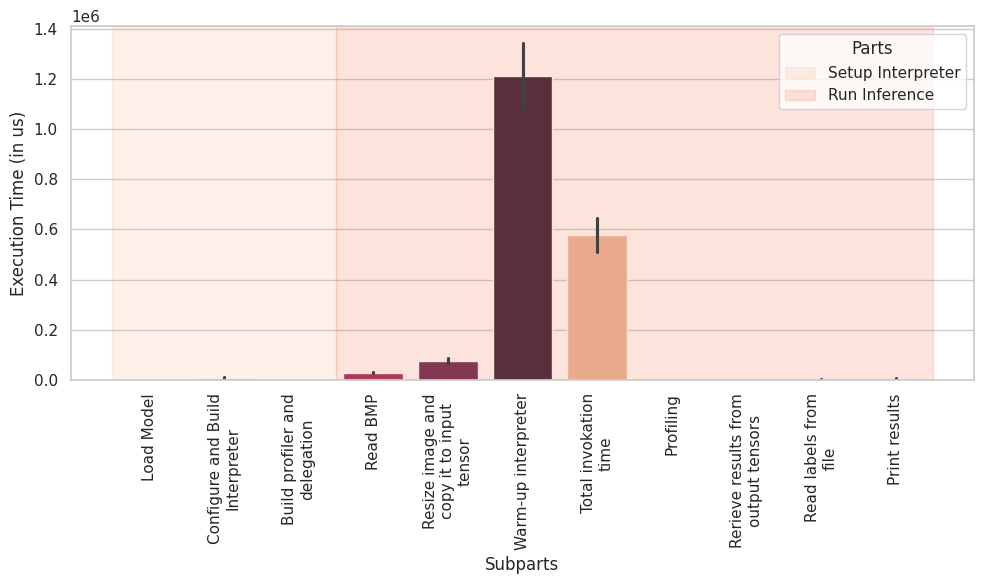

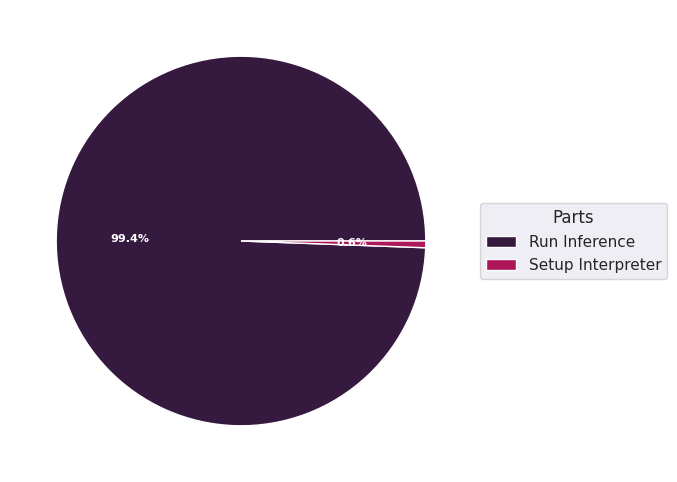

/tmp/ipykernel_300735/3586007223.py:30: UserWarning: 
The palette list has fewer values (6) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=item, x='Subpart', y='Execution Time (in us)', order=subpart_order, palette=colors)


<Figure size 640x480 with 0 Axes>

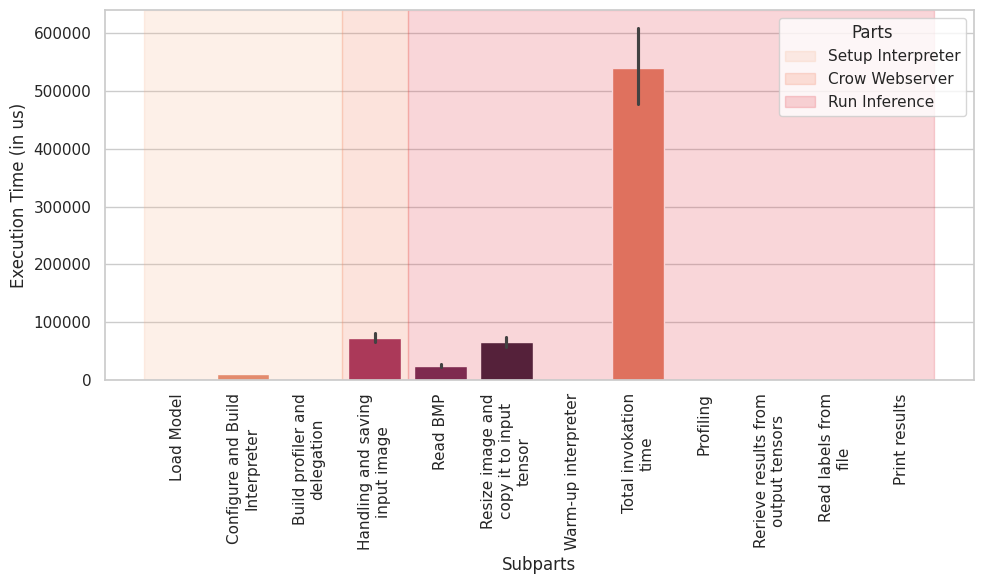

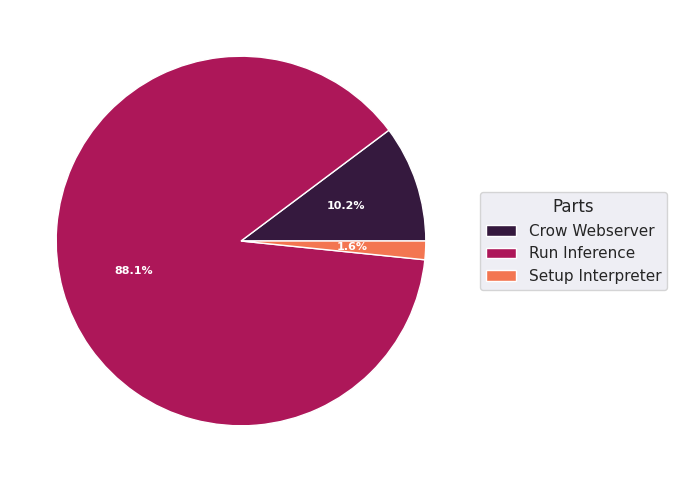

/tmp/ipykernel_300735/3586007223.py:30: UserWarning: 
The palette list has fewer values (3) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=item, x='Subpart', y='Execution Time (in us)', order=subpart_order, palette=colors)


<Figure size 640x480 with 0 Axes>

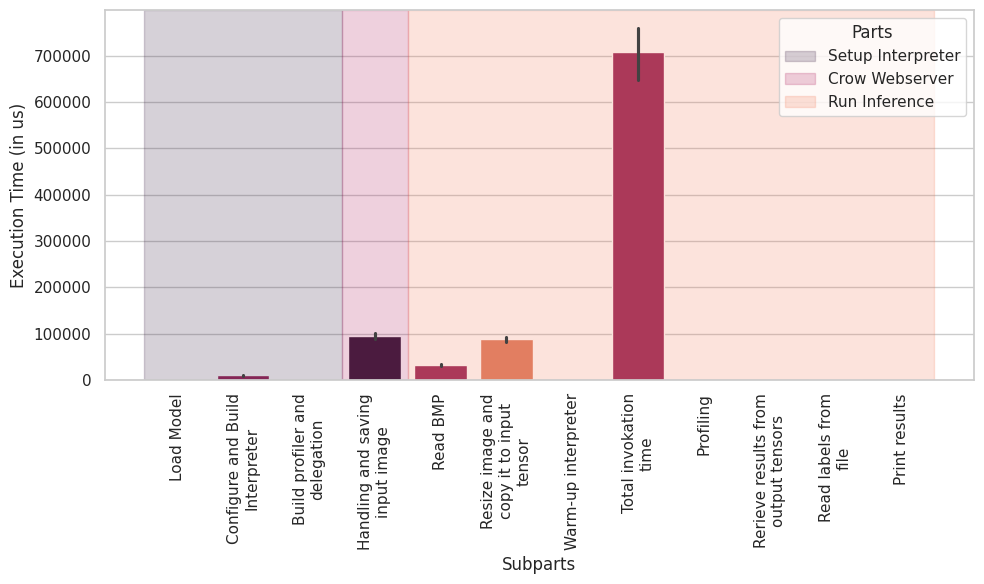

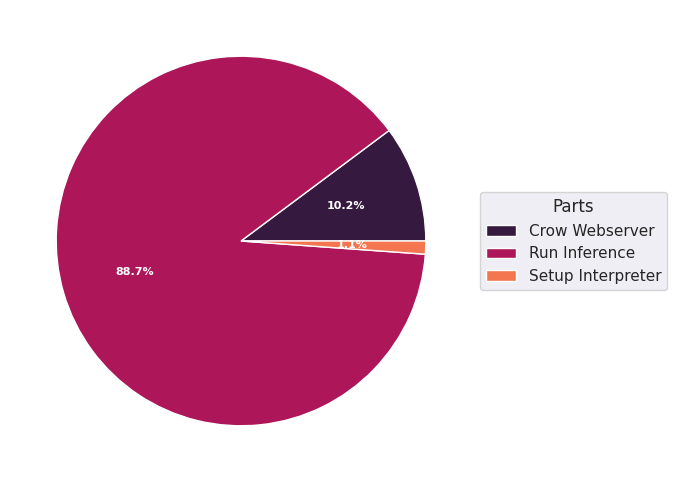

/tmp/ipykernel_300735/3586007223.py:30: UserWarning: 
The palette list has fewer values (3) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=item, x='Subpart', y='Execution Time (in us)', order=subpart_order, palette=colors)


<Figure size 640x480 with 0 Axes>

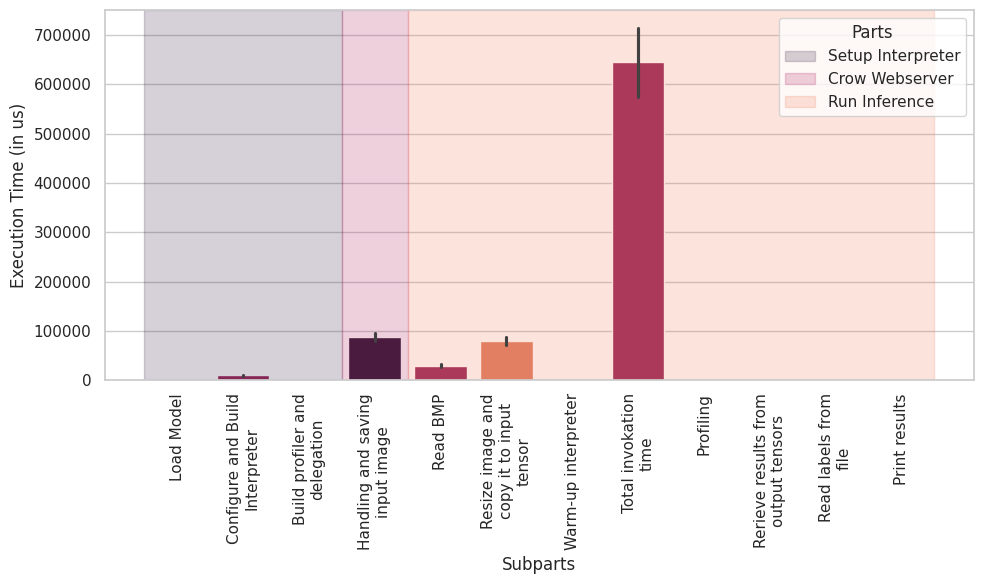

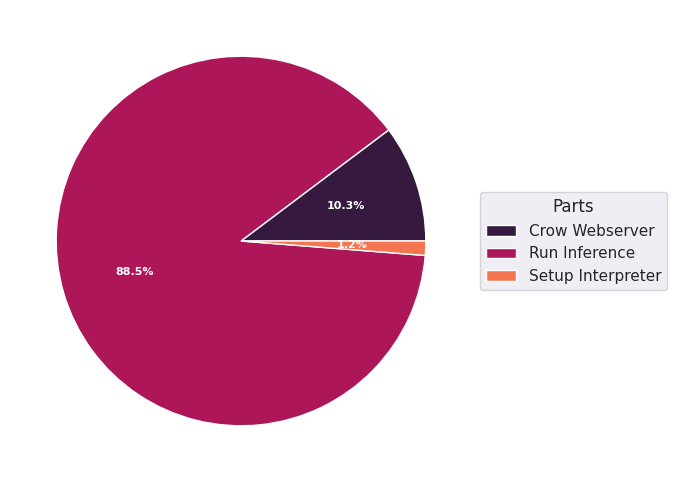

<Figure size 640x480 with 0 Axes>

In [97]:
df_exec_time = pd.read_csv(exp_dir + "/execution_time_by_parts.csv")
df_cpu_usage = pd.read_csv(exp_dir + "/cpu_usage.csv")
df_ram_usage = pd.read_csv(exp_dir + "/ram_usage.csv")

for imp in implementations:
    df_exec_time_imp = df_exec_time[df_exec_time["Implementation"] == imp]
    # mask = df_exec_time_imp[(df_exec_time_imp["Subpart"] != "Global time") & (df_exec_time_imp["Subpart"] != "Run inference") & (df_exec_time_imp["Subpart"] != "Average invokation time per loop")]
    df_exec_time_imp = df_exec_time_imp[(df_exec_time_imp["Subpart"] != "Global time") & (df_exec_time_imp["Subpart"] != "Run inference") & (df_exec_time_imp["Subpart"] != "Average invokation time per loop")]
    df_exec_time_imp['Subpart'] = df_exec_time_imp['Subpart'].apply(lambda x: textwrap.fill(x, width=20))
    df_cpu_usage_imp = df_cpu_usage[df_cpu_usage["Implementation"] == imp]
    df_ram_usage_imp = df_ram_usage[df_ram_usage["Implementation"] == imp]

    df_exec_time_imp_med = df_exec_time_imp.groupby(["Medium"])

    medium_group = df_exec_time_imp.groupby("Medium")

    colors = sns.color_palette('rocket')[::-1]

    part_subpart_order = df_exec_time_imp[["Part", "Subpart"]].drop_duplicates()
    part_order = part_subpart_order["Part"].unique()
    subpart_order = part_subpart_order["Subpart"].to_list()
    
    # Generate unique colors for each part
    # colors = plt.cm.viridis([i / float(len(part_order)) for i in range(len(part_order))])

    for med, item in medium_group:
        # Bar plot
        plt.figure(figsize=(10, 6))
        sns.set_style("whitegrid")
        sns.barplot(data=item, x='Subpart', y='Execution Time (in us)', order=subpart_order, palette=colors)

        # Add background colors
        start_idx = 0
        start_idx = 0
        for i, part in enumerate(part_order):
            part_count = len(part_subpart_order[part_subpart_order["Part"] == part])
            end_idx = start_idx + part_count
            plt.axvspan(start_idx - 0.5, end_idx - 0.5, color=colors[i], alpha=0.2, label=part)
            start_idx = end_idx
        
        plt.legend(title="Parts")
        plt.xlabel("Subparts")
        plt.xticks(rotation=90)
        plt.ylim(bottom=0)
        plt.tight_layout()
        plt.show
    
        plt.savefig(graphs_exec_time_dir + "/barplot_" + experiment_name.replace(' ', '_') + "_" + imp + "_" + med + ".pdf")

        # Pie plot
        fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))

        colors = sns.color_palette('rocket')[0::2] 
        sns.set_theme()

        data_by_part = item.groupby("Part").sum()
        data_by_part["Execution Time (in us)"] = data_by_part["Execution Time (in us)"] / data_by_part["Execution Time (in us)"].sum()

        wedges, texts, autotexts = ax.pie(data_by_part["Execution Time (in us)"], autopct='%1.1f%%', colors=colors, startangle=0)

        for text in plt.gca().texts:
            text.set_color('white')
            # text.set_fontsize(20)
        for autotext in autotexts:
            autotext.set_color('white')
            # autotext.set_fontsize(20)

        ax.legend(wedges, data_by_part.index.values,
                title="Parts",
                loc="center left",
                bbox_to_anchor=(1, 0, 0.5, 1))

        plt.setp(autotexts, size=8, weight="bold")

        plt.show()
        plt.savefig(graphs_exec_time_dir + "/pieplot_" + experiment_name.replace(' ', '_') + "_" + imp + "_" + med + ".pdf")

/tmp/ipykernel_300735/2432963035.py:33: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.barplot(data=item_group, x='Execution Time (in us)', y='Part', orient="y", order=label_order, palette=colors)


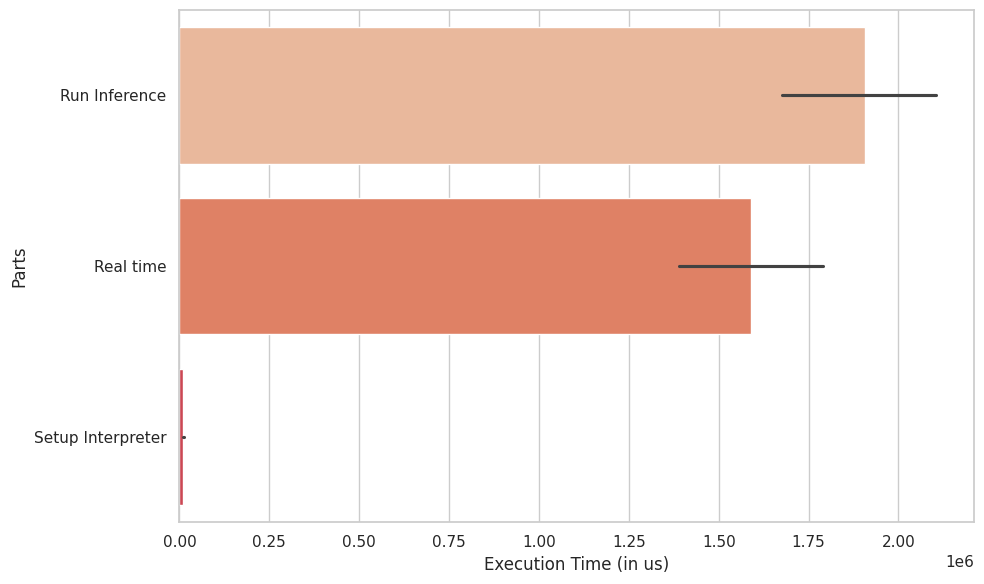

/tmp/ipykernel_300735/2432963035.py:33: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.barplot(data=item_group, x='Execution Time (in us)', y='Part', orient="y", order=label_order, palette=colors)


<Figure size 640x480 with 0 Axes>

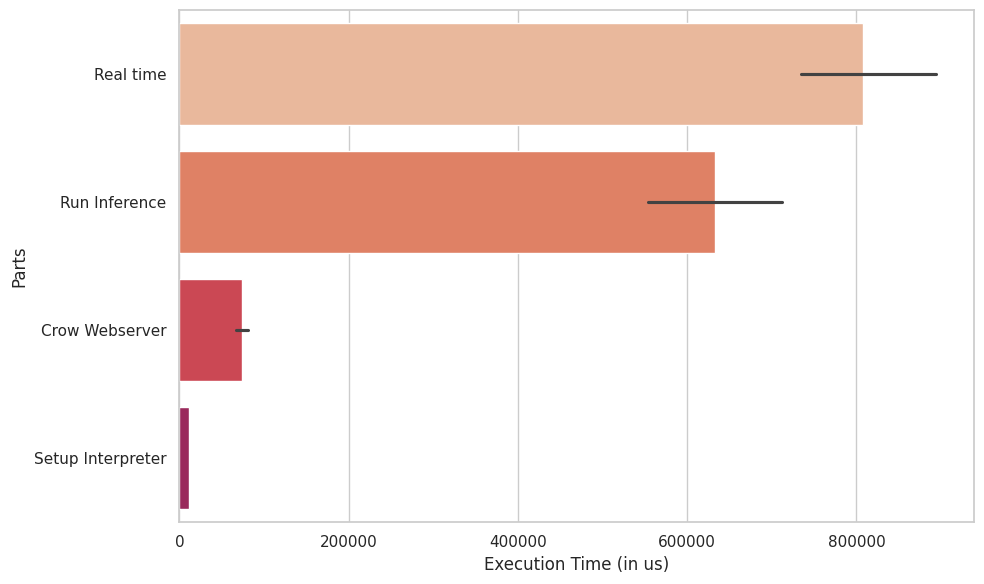

/tmp/ipykernel_300735/2432963035.py:33: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.barplot(data=item_group, x='Execution Time (in us)', y='Part', orient="y", order=label_order, palette=colors)


<Figure size 640x480 with 0 Axes>

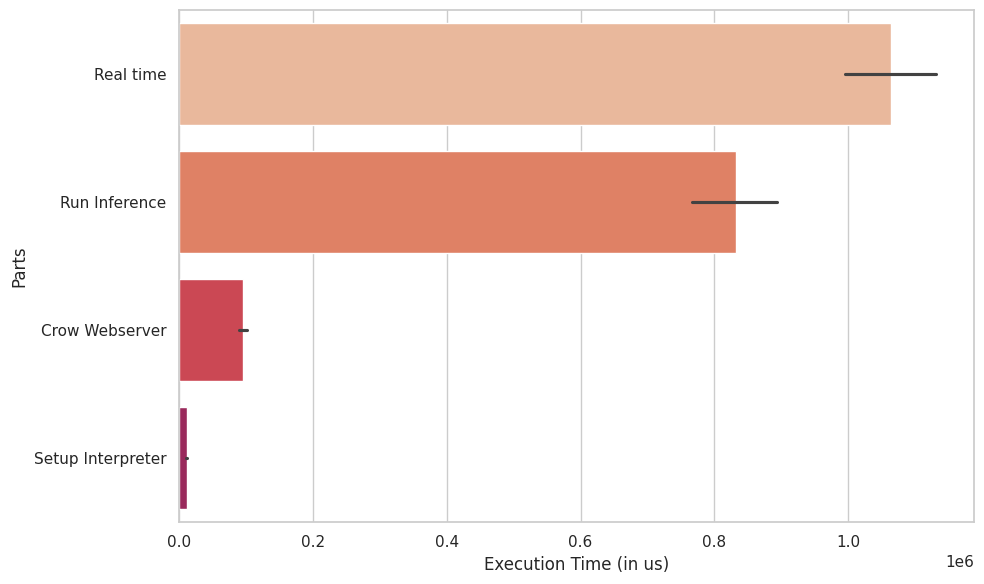

/tmp/ipykernel_300735/2432963035.py:33: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.barplot(data=item_group, x='Execution Time (in us)', y='Part', orient="y", order=label_order, palette=colors)


<Figure size 640x480 with 0 Axes>

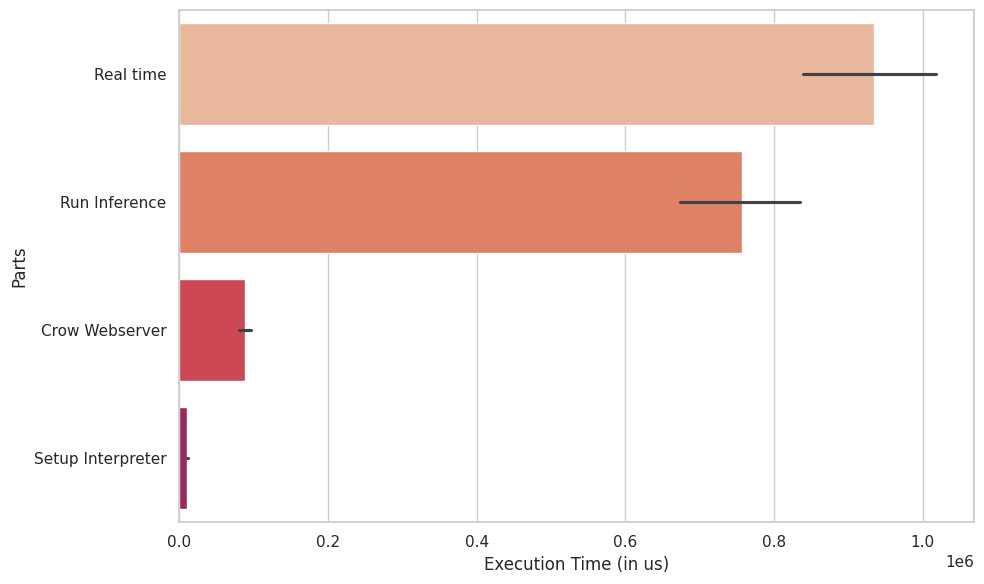

<Figure size 640x480 with 0 Axes>

In [98]:
df_exec_time = pd.read_csv(exp_dir + "/execution_time_by_parts.csv")
df_cpu_usage = pd.read_csv(exp_dir + "/cpu_usage.csv")
df_ram_usage = pd.read_csv(exp_dir + "/ram_usage.csv")

for imp in implementations:
    df_exec_time_imp = df_exec_time[df_exec_time["Implementation"] == imp]
    df_exec_time_imp = df_exec_time_imp[((df_exec_time_imp["Subpart"] != "Global time") | (df_exec_time_imp["Part"] == "Real time")) & (df_exec_time_imp["Subpart"] != "Run inference") & (df_exec_time_imp["Subpart"] != "Average invokation time per loop")]
    df_exec_time_imp['Subpart'] = df_exec_time_imp['Subpart'].apply(lambda x: textwrap.fill(x, width=20))
    df_cpu_usage_imp = df_cpu_usage[df_cpu_usage["Implementation"] == imp]
    df_ram_usage_imp = df_ram_usage[df_ram_usage["Implementation"] == imp]

    df_exec_time_imp_med = df_exec_time_imp.groupby(["Medium"])

    medium_group = df_exec_time_imp.groupby("Medium")

    colors = sns.color_palette('rocket')[::-1]
    # Generate unique colors for each part
    # colors = plt.cm.viridis([i / float(len(part_order)) for i in range(len(part_order))])

    for med, item in medium_group:
        # Process data
        item = item[["Iteration", "Part", "Execution Time (in us)"]]
        item_group = item.groupby(["Iteration", "Part"]).sum()

        # Get order
        label_order = item_group.groupby("Part").mean().sort_values(by=["Execution Time (in us)"], ascending=False)
        label_order.reset_index(inplace=True)
        label_order = label_order["Part"]

        # Bar plot
        plt.figure(figsize=(10, 6))
        sns.set_style("whitegrid")
        sns.barplot(data=item_group, x='Execution Time (in us)', y='Part', orient="y", order=label_order, palette=colors)
        
        # plt.xticks(rotation=90)
        plt.xlim(left=0)
        plt.ylabel("Parts")
        plt.tight_layout()
        plt.show()
    
        plt.savefig(graphs_exec_time_dir + "/barplot_global_" + experiment_name.replace(' ', '_') + "_" + imp + "_" + med + ".pdf")
